# Carlos Adrián García Estrada A01707503
# Iván Ricardo Paredes Avilez A01705083
# Francisco Couttolenc Ortíz A01754959
# Fecha de entrega: 19 de noviembre de 2023

#  Situación: 

    El reto consiste en desarrollar un sistema multiagente para resolver una tarea cooperativa en un entorno 20x20 dinámicamente cambiante. El entorno del sistema multiagente es un mundo similar a una cuadrícula donde los agentes pueden moverse de su posición a una celda vecina si ya no hay ningún agente en esa ranura. En este entorno, la comida puede aparecer en cualquier celda menos en una. La celda especial, en la que no puede aparecer comida, se considera un depósito donde los agentes pueden traer y almacenar su comida. Un agente puede sólo puede saber si hay comida en una celda, si está visitándola. Inicialmente, la comida se coloca en algunas celdas aleatorias. Durante la ejecución, puede aparecer comida adicional dinámicamente en celdas seleccionadas al azar, excepto en la celda del depósito. Los agentes pueden tener/desempeñar diferentes roles (como explorador o recolector), comunicarse y cooperar para encontrar y recolectar alimentos de manera eficiente y efectiva.

# Solución: 
 
    Se creo un sistema multiagente donde en cada paso los agentes siempre revisarán sus alrededores e identificarán si hay celdas vacías, celdas con comida y el depósito. El modelo actualizará las celdas de comida y depostio cada vez que un agente identifiqué celdas nuevas con comida. El comportamiento del agente dependerá si tiene comida. Si el agente tiene comdia evaluará su posición y la del deposito decidiendo dirigirse o no dependiendo si las coordenadas ya han sido encontradas, de otro modo el agente se moverá de manera aleatoria. En el caso de que el agente no tenga comida, revisará si la celda que se encuentra actualmente o la de sus alrededores tiene comida la cual tomará en ese turno o el siguiente; también revisará si hay coordendas de comida encontrada por el u otros agentes y se dirigirá a aquella más cercana. En caso de que ninguna de estas condiciones qse cumpla entonces el agnete se moverá aleatoriamente. El agente colocará comida si y solo si se encuentra en la celda del deposito y tomará comida si y solo si la celda en la que se encuentra tiene comida y no está marcada como depósito. Para el movimiento dirigido por coordenadas el agente usará la distancia manhattan para moverse de manera directa al objetivo (depósito o comida)

# Como eficientar el algoritmo 

    Implementar otro array que contenga todas las coordenadas de la celda y que el agente en caso de que ninguna de las condiciones previamente explicadas, en vez de moverse aleatoriamente se mueva a alguna coordenada que aún no haya sido visitada o poco visitada. 

In [1]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Elegimos mulyigrid por la facilidad de manejo de contenido en celdas
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen uno a la vez
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

#Importamos random para obtener coordenadas al azar y math para el calculo de la distancia manhattna
import random
import math

#Tipos
#Type 1 Food
#Type 2 deposit 

In [2]:
class FoodAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.has_food = False
        self.deposit_coordinates = None # Inicialmente no se conocen las coordenadas del depósito
        self.food_coordinates = None  # Coordenadas para dirigirse a comida
        self.random.seed(12345)
#el método step del agente, se utiliza esta función para intentar obtener las coordenadas de la comida. 
#Si el agente no tiene comida, intentará moverse hacia la comida si hay coordenadas disponibles.

    def step(self):

        #Obtenemos las posibles celdas a las que el agente se puede mover
        neighborhood = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)

        # Se filtran las celdas vacías entre las celdas vecinas
        empty_cells = [cell for cell in neighborhood if (self.model.grid.is_cell_empty(cell) and self.model.get_type(cell[0], cell[1]) == 0)]                                                     
        
        # Se filtran las celdas de comida 
        food_cells = [cell for cell in neighborhood if (self.model.grid.is_cell_empty(cell) and self.model.get_type(cell[0], cell[1]) == 1)]     
    
         # Se filtra la celda de depósito
        deposit_cell = [cell for cell in neighborhood if (self.model.grid.is_cell_empty(cell) and self.model.get_type(cell[0], cell[1]) == 2)] 

        # Actualiza las coordenadas del deposito en el modelo en caso de que esté en su vecindario
        if deposit_cell:            
            deposit_coordinates = deposit_cell[0]

            self.model.update_deposit_coordinates(deposit_coordinates[0], deposit_coordinates[1])
            
        # Actualiza las coordenadas de la comida en el modelo en caso de que haya comida en su vecindario
        if food_cells:
            self.model.update_food_coordinates(food_cells)

        #El agente hace un a llamada para obtener las coordenadas del deposito en caso de que se hayan guardado
        if self.deposit_coordinates is None:
            self.deposit_coordinates = self.model.get_deposit_coordinates()


            # Si el agente no tiene comida
        if not self.has_food:

            #calcula aquellas posiciones de comida a las que puede ir 
            food_moves = self.model.get_food_coordinates(self.pos[0], self.pos[1])
            # Si la celda actual tiene comida y no es un depósito, recoge la comida                 
            if self.model.get_type(self.pos[0], self.pos[1]) == 1:
                self.model.take_food(self.pos[0], self.pos[1])
                self.has_food = True

                # Si hay coordenadas del depósito, muévete hacia el depósito
                if self.deposit_coordinates is not None:
                    self.move_to_deposit(empty_cells)

                else:
                    self.model.grid.move_agent(self, self.random.choice(empty_cells))

            # Si hay celdas con comida en el vecindario mueve el agente hacia allá
            elif food_cells:

                food_cell = self.random.choice(food_cells)

                self.model.grid.move_agent(self, food_cell)

            # Si no hay celdas con comida en el vecindario el agente busca si hay coordenadas guardas en el array y si hay se mueve  
            elif food_moves:
                self.food_coordinates = food_moves
                self.move_to_food(empty_cells)

            #Si ninguna de estas es verdadera, mueve el agente a una posición random en empty cells
            else:
                self.model.grid.move_agent(self, self.random.choice(empty_cells))               

        #Si el agente tiene comida
        else:
            #Si el agente está actualmente en el deposito, coloca la comida
            if self.model.get_type(self.pos[0], self.pos[1]) == 2:
                self.model.place_food()
                self.has_food = False
            
            #Si no esta en el deposito pero tiene las coordenadas que se mueva a las coordenadas
            elif self.deposit_coordinates is not None:
                self.move_to_deposit(empty_cells)

            #Si no hya coordenadas de deposito muevete a una celda vacía     
            else:
                self.model.grid.move_agent(self, self.random.choice(empty_cells))

    # Mueve al agente hacia el depósito utilizando la distancia de Manhattan.
    def move_to_deposit(self, empty_cells):
        """
        Mueve al agente hacia la posición de la comida utilizando la distancia de Manhattan.
        La distancia de Manhattan se define como la suma de las diferencias absolutas de las coordenadas en cada dimensión
        d = |x1 - x2| + |y1 - y2|
        """
        if self.deposit_coordinates is not None:

            deposit_row, deposit_col = self.deposit_coordinates
            current_row, current_col = self.pos

            delta_row = 0
            delta_col = 0

            x = deposit_row - current_row
            y = deposit_col - current_col

            # Revisa que dirección es más beneficiosa
            if abs(x) > abs(y):
                delta_row = int(math.copysign(1, x))
            else:
                delta_col = int(math.copysign(1, y))

            # Calcula la nueva posición
            new_row = int(current_row + delta_row)
            new_col = int(current_col + delta_col)
            new_position = (new_row, new_col)

            # Revisa sie s posible moverse a esa celda, de lo contrario se mueve a una celda vacía
            if self.model.grid.is_cell_empty(new_position):
                self.model.grid.move_agent(self, new_position)
            else:
                self.model.grid.move_agent(self, self.random.choice(empty_cells))

    def move_to_food(self, empty_cells):
        """
        Mueve al agente hacia la posición de la comida utilizando la distancia de Manhattan.
        La distancia de Manhattan se define como la suma de las diferencias absolutas de las coordenadas en cada dimensión
        d = |x1 - x2| + |y1 - y2|
        """
        if self.food_coordinates is not None:
            food_row, food_col = self.food_coordinates
            current_row, current_col = self.pos

            delta_row = 0
            delta_col = 0

            # Calcula la distancia de Manhattan
            x = food_row - current_row
            y = food_col - current_col

            # Comprueba la dirección preferida (x o y) basándose en la distancia mayor
            if abs(x) > abs(y):
                delta_row = int(math.copysign(1, x))
            else:
                delta_col = int(math.copysign(1, y))

            # Mueve al agente solo un paso en la dirección preferida
            new_row = int(current_row + delta_row)
            new_col = int(current_col + delta_col)
            new_position = (new_row, new_col)

            # Verifica si la nueva posición es válida antes de realizar el movimiento
            if self.model.grid.is_cell_empty(new_position):
                self.model.grid.move_agent(self, new_position)
            else:
                self.model.grid.move_agent(self, self.random.choice(empty_cells))


In [3]:
#En get_grid obtenemos los contenidos de nuestra celda y seteamos valores numéricos
#para después setear los colores en el grid

def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height), dtype=int)
    
    for (content, (x, y)) in model.grid.coord_iter():

        if content:
            grid[x][y] = 1   #Agent

        elif model.get_type(x, y) == 1: 
            grid[x][y] = 2  #Comida

        elif model.get_type(x, y) == 2: 
            grid[x][y] = 3 #Deposito

        else:
            grid[x][y] = 0  # Empty cell

    return grid


In [4]:
class FoodModel(Model):
    def __init__ (self, width, height, num_agents, num_food):
        super().__init__(width, height)
        self.num_food = num_food
        self.food_in_deposit = 0
        self.num_agents = num_agents
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})  
        self.type = np.zeros((width, height))
        self.deposit_coordinates = None
        self.food_coordinates = []
        self.is_deposit = np.zeros((width, height))
        self.running = True
        self.step_call_count = 0
        self.random.seed(12345)
        
        #añadimos una id única a los agentes

        #self.type  = 0 vacío
        #self.type  = 1 comida
        #self.type  = 2 deposito

        id = 0

        #Iniciamos variables en cero
        for x in range(width):
            for y in range(height):
                self.type[x][y] = 0

        #Ponemos agentes en random
        for i in range(num_agents):
            x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)

            while not (self.grid.is_cell_empty((x, y))):
                 x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)    
            
            fooder = FoodAgent(id, self)
            self.grid.place_agent(fooder, (x, y))
            self.schedule.add(fooder)
            id = id + 1

        #Ponemos coordenadas del deposito random
        x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)
        while not (self.grid.is_cell_empty((x, y))):
                 x, y = random.randrange(self.grid.width), random.randrange(self.grid.height)
        if (self.grid.is_cell_empty((x, y))):
                self.type[x][y] = 2

    def step(self):

        #Checamos que el contador de food in deposit para saber si ha llegado a 47
        self.step_call_count += 1

        if(self.step_call_count % 5 == 0):
            self.generate_food()         
        self.datacollector.collect(self)
        self.schedule.step() 

        if self.food_in_deposit == 47:
            self.running = False

    def get_type(self, x,y):
        return self.type[x][y]
         
    def generate_food(self):

        #Esta función cuenta la cantidad de comida, y elige un número random para setear celdas con una unidad de comida  
        if self.num_food > 0:     

            if self.num_food >= 5:
                cell_quantity = self.random.randint(2,5) 
            
            elif self.num_food == 4:
                cell_quantity = self.random.randint(2,4) 

            elif self.num_food == 3:
                cell_quantity = self.random.randint(2,3) 

            elif self.num_food == 2:
                cell_quantity = self.random.randint(1,2) 
            
            else:
                cell_quantity = 1

            self.num_food -= cell_quantity

            for i in range(cell_quantity):      
                x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
                while not (self.grid.is_cell_empty((x, y)) and self.get_type(x,y)== 0 ):
                    x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height) 

                self.type[x][y] = 1


    def update_deposit_coordinates(self, x, y):

        if x is not None and y is not None:
            self.deposit_coordinates = (x, y)

    #El modelo recibe un array de comida encontrada en el vecindario del agente, solo va a agregar aquellas coordenadas que no tiene
    def update_food_coordinates(self, cells):
        if cells:
            for cell in cells:
                x, y = cell
                if (x, y) not in self.food_coordinates:
                    self.food_coordinates.append((x, y))

    # Cada vez que el agente toma comida. se borra la coordenada del array de comida en caso de que se encuentre
    def take_food(self, x, y):
        self.type[x][y] -= 1
        
        if (x, y) in self.food_coordinates:
            self.food_coordinates.remove((x, y))

    def place_food(self):
        self.food_in_deposit += 1
        
    def get_food_coordinates(self, x, y):
        """
        Devuelve las coordenadas de la comida más cercana al agente.

        Parameters:
            current_position: Tupla (x, y) que representa la posición actual del agente.

        Returns:
            Tupla (x, y) de las coordenadas de la comida más cercana o None si no hay comida en el vecindario.
        """
        if not self.food_coordinates:
            return None
        
        current_position = (x,y)

        # Calcula las distancias de Manhattan entre la posición actual del agente y las coordenadas de la comida
        distances = [abs(current_position[0] - food[0]) + abs(current_position[1] - food[1]) for food in self.food_coordinates]

        # Encuentra el índice de la comida más cercana
        closest_food_index = np.argmin(distances)

        # Devuelve las coordenadas de la comida más cercana
        return self.food_coordinates[closest_food_index]
    
    def get_deposit_coordinates(self):
        # Regresa las coordenadas del deposito
        return self.deposit_coordinates
    

In [5]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
NUM_FOOD = 47

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()

model = FoodModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_FOOD)
step_counter = 0 
#llamamos al modelo y contamos los steps hasta que acabe
while model.running:
    model.step()
    step_counter += 1

# Imprimimos el tiempo que le tomó correr al modelo.
print('Numero de pasos:', step_counter)
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Numero de pasos: 829
Tiempo de ejecución: 0:00:00.297150


In [6]:
#Recolectamos los datos del grid 
all_grid = model.datacollector.get_model_vars_dataframe()

C:\Users\cgare\AppData\Local\Temp\ipykernel_23980\3136879400.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=3)
C:\Users\cgare\AppData\Local\Temp\ipykernel_23980\3136879400.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])


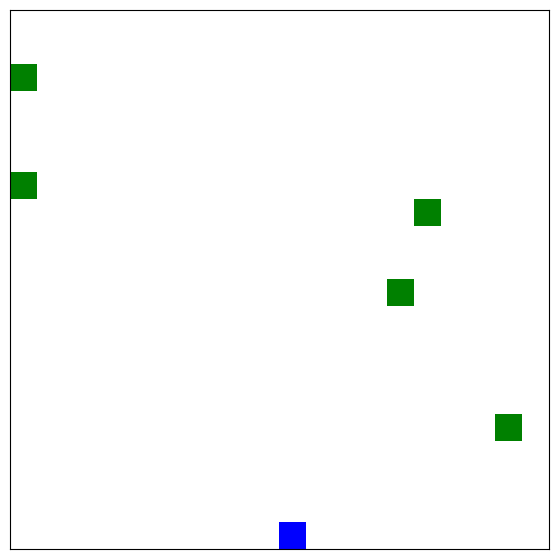

In [7]:

fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])

# Definimos el color para la distinguir agentes, y celdas con comida y deposito
#el numero que seteamos anteriormente corresponde al valor del array
#de colores que queremos que se muestre 
cmap = plt.cm.colors.ListedColormap(['white', 'green', 'red', 'blue'])

patch = plt.imshow(all_grid.iloc[0][0], cmap=cmap, vmin=0, vmax=3)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    patch.set_clim(vmin=0, vmax=3)  #establecemos los limites del color

anim = animation.FuncAnimation(fig, animate, frames=step_counter)

In [8]:
anim

C:\Users\cgare\AppData\Local\Temp\ipykernel_23980\3136879400.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(all_grid.iloc[i][0])
